In [1]:
import numpy as np
from pathlib import Path
import pathlib
from os import listdir
from os.path import isfile, join, exists

from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops, regionprops_table
from skimage import io
from skimage.transform import resize

import pylab

# %matplotlib inline 
%matplotlib widget 
from matplotlib import pyplot as plt
import ImageAnalysis
import Morphology
import cv2 

import pandas as pd 

from IPython.display import display
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
import ipywidgets as widgets

In [4]:
input_path = "C:\RESEARCH\Mitophagy_data\Threshold Test Data\Input Data\\"
images = [[input_path + f, f] for f in listdir(input_path) if isfile(join(input_path, f))]
print(images)

[['C:\\RESEARCH\\Mitophagy_data\\Threshold Test Data\\Input Data\\CCCP+Baf_2C=0.tif', 'CCCP+Baf_2C=0.tif'], ['C:\\RESEARCH\\Mitophagy_data\\Threshold Test Data\\Input Data\\CCCP+Baf_2C=1.tif', 'CCCP+Baf_2C=1.tif'], ['C:\\RESEARCH\\Mitophagy_data\\Threshold Test Data\\Input Data\\CCCP_1C=0.tif', 'CCCP_1C=0.tif'], ['C:\\RESEARCH\\Mitophagy_data\\Threshold Test Data\\Input Data\\CCCP_1C=1.tif', 'CCCP_1C=1.tif'], ['C:\\RESEARCH\\Mitophagy_data\\Threshold Test Data\\Input Data\\CCCP_2C=0.tif', 'CCCP_2C=0.tif'], ['C:\\RESEARCH\\Mitophagy_data\\Threshold Test Data\\Input Data\\CCCP_2C=1.tif', 'CCCP_2C=1.tif'], ['C:\\RESEARCH\\Mitophagy_data\\Threshold Test Data\\Input Data\\Con_1C=0.tif', 'Con_1C=0.tif'], ['C:\\RESEARCH\\Mitophagy_data\\Threshold Test Data\\Input Data\\Con_1C=2.tif', 'Con_1C=2.tif'], ['C:\\RESEARCH\\Mitophagy_data\\Threshold Test Data\\Input Data\\Con_2C=0.tif', 'Con_2C=0.tif'], ['C:\\RESEARCH\\Mitophagy_data\\Threshold Test Data\\Input Data\\Con_2C=2.tif', 'Con_2C=2.tif'], [

In [5]:
def displayImages(img, title):
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(10, 7)
    ax1.imshow(img, interpolation='nearest')
    ax1.set_title(title)

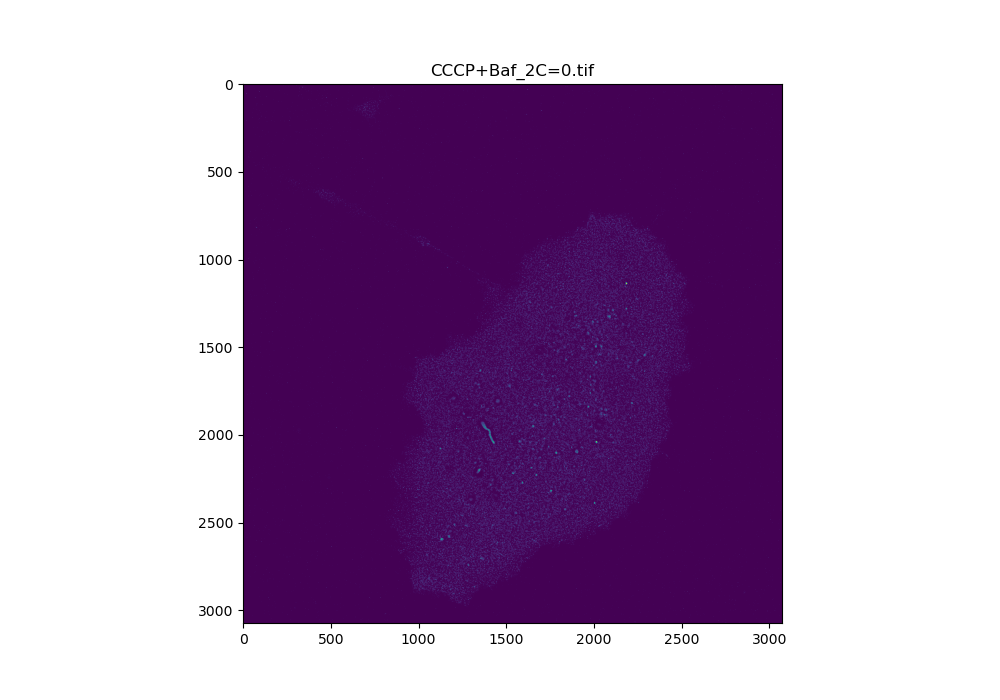

In [6]:
displayImages(io.imread(images[0][0])[0], images[0][1])

In [7]:
def adaptive_threshold_stack(input_image, block_size = 100, constant = -30):
    if block_size % 2 != 1:
        block_size += 1

    thresholded = []
    for i in range(input_image.shape[0]):
        thresholded.append(cv2.adaptiveThreshold(input_image[i], 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                                  cv2.THRESH_BINARY, block_size, constant)) # ADAPTIVE_THRESH_MEAN_C
    return np.array(thresholded)

In [8]:
def update(val):
    global z
    global block_size
    global constant
    global stack
    global ax2
    global ax
    global centers
    global gradient
    global gradient2
    global crop_s_XY
    global crop_e_XY
    thresholded = adaptive_threshold_stack(stack, int(block_size.val), int(constant.val))
    #thresholded = binarizeStack(stack)
    stackRGB = np.stack((stack, stack, stack), axis=-1)
    thresholdedRGB = np.stack((thresholded, np.zeros_like(thresholded),np.zeros_like(thresholded)), axis=-1)
    finalStack = stackRGB *0.6 + thresholdedRGB *0.4
    #ax2.imshow(stack[int(z.val)])
    # ax2.imshow(finalStack[int(z.val),crop_s_XY[0]:crop_e_XY[0], crop_s_XY[1]:crop_e_XY[1]]/255)
    ax2.imshow(finalStack[int(z.val),:,:]/255)

In [9]:
def chooseAdaptiveThresholding(img_stack, default_block_size=150, default_constant=-10):
    global z
    global block_size
    global constant
    global stack
    global ax2
    global ax
    global centers
    global gradient
    global gradient2
    global crop_s_XY
    global crop_e_XY
    ax = None
    ax2 = None
    # if np.max(img_stack) > 1:
    #     img_stack = img_stack / 255
    crop_s_XY = [400, 400]
    crop_e_XY = [1300, 1100]

    stack = img_stack

    BlockSizeInit = default_block_size
    ConstantInit = default_constant

    fig = plt.figure()
    fig.set_size_inches(15, 15)
    fig.tight_layout()
    # ax = plt.subplot(121)
    # plt.subplots_adjust(left=0.15, bottom=0.4)    

    # ax.grid(False)
    # ax.title('Choose hysteresis thresholds')
    # ax.xlabel('Intensity')
    # ax.ylabel('concentration')

    axcolor = 'lightgoldenrodyellow'
    axBlockSize = plt.axes([0.15, 0.3, 0.65, 0.03], facecolor=axcolor)
    axConstant = plt.axes([0.15, 0.35, 0.65, 0.03], facecolor=axcolor)
    axZ = plt.axes([0.15, 0.40, 0.65, 0.03], facecolor=axcolor)

    block_size = pylab.Slider(axBlockSize, 'BlockSize', 0, 250, valinit=BlockSizeInit, valstep = 1)
    constant = pylab.Slider(axConstant, 'Constant', -50, 50, valinit=ConstantInit, valstep = 1)
    z = pylab.Slider(axZ, 'z', 0, stack.shape[0] - 1, valinit=2, valstep = 1)

    ax2 = plt.subplot(211)
    plt.subplots_adjust(hspace = .001)
    thresholded = adaptive_threshold_stack(stack, int(block_size.val), int(constant.val))
    #thresholded = binarizeStack(stack)
    stackRGB = np.stack((stack, stack, stack), axis=-1)
    thresholdedRGB = np.stack((thresholded, np.zeros_like(thresholded),np.zeros_like(thresholded)), axis=-1)
    finalStack = stackRGB *0.6 + thresholdedRGB *0.4
    #ax2.imshow(stack[int(z.val)])
    # ax2.imshow(finalStack[int(z.val),crop_s_XY[0]:crop_e_XY[0], crop_s_XY[1]:crop_e_XY[1]]/255)
    ax2.imshow(finalStack[int(z.val),:,:]/255)

    block_size.on_changed(update)
    constant.on_changed(update)
    z.on_changed(update)

    plt.show()

In [22]:
image_selecter = widgets.IntSlider(description='Sample', min=0, max=len(images)-1)
def adaptiveAdjust(image, value1, value2):
    #stack.shape[0] - 1 #for z limit
    return value1, value2
    

In [29]:
def f(x):
    return x
interact(f, x=image_selecter)

interactive(children=(IntSlider(value=0, description='Sample', max=15), Output()), _dom_classes=('widget-inter…

<function __main__.f(x)>